In [1]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [2]:
# Import libraries
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle

%matplotlib widget

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
rextract = 0
load_data = 0
n_cases = 26
# Load data
# fig, ax = plt.subplots(2,5)
segs = []
qsms = []
voxel_sizes = []
trackers = []
directory = 'F:\dbs\stn-dbs\Cornell_anonymized'
case_list = []
if load_data == 1:
    for filename in os.listdir(directory):
        f = os.path.join(directory,filename)
        print(f)
    
        seg = nib.load(f+'/Rh Mri Brain With Without Contrast/seg.nii.gz')
                    
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata())

        qsm = nib.load(f+'/Rh Mri Brain With Without Contrast/qsm.nii.gz')
        qsms.append(qsm.get_fdata())
            
        case_list.append(filename)
        n_cases = len(segs)

        label_min = np.partition(np.unique(seg.get_fdata().ravel()), 1)[1]
        label_max = np.amax(seg.get_fdata())

In [4]:
# Define feature extraction
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()
extractor.enableAllImageTypes()

# Generate feature structure Phi from all ROIs and all cases
if rextract == 1:
    Phi = []

    # Training cases
    for i in range(n_cases):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_sizes[i].tolist())
        qsm_sitk = sitk.GetImageFromArray(qsms[i])
        qsm_sitk.SetSpacing(voxel_sizes[i].tolist())
        for j in range(int(label_min),int(label_max+1)):
            featureVector = extractor.execute(qsm_sitk,seg_sitk,label=j)
            Phi.append(featureVector)
    # Save feature vector
    with open('../features/Phi_57', 'wb') as fp:  
        pickle.dump(Phi, fp)


In [5]:
with open('../features/Phi_57', "rb") as fp:  
    Phi = pickle.load(fp)

In [6]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

In [7]:
# UPDRS features
subject_id = np.array((1,2,3,6,9,10,11,12,13,15,16,20,25,26,27,28,29,34,35,41,43,44,45,46,52,54))
pre_updrs_iii_off = np.array((65,22,45,63,63,27,57,42,54,67,33,27,50,77,43,31,56,81,40,28,52,32,33,18,58,63))
pre_updrs_iii_on = np.array((54,7,13,32,21,14,11,14,28,65,9,4,26,55,14,8,24,20,17,0,29,13,26,0,27,36))
post_updrs_iii_off = np.array((11,2,20,3,7,11,15,21,16,21,4,9,15,9,11,4,8,25,13,16,7,26,2,8,19,8))
per_change = (pre_updrs_iii_off-post_updrs_iii_off)/pre_updrs_iii_off
lct_change = (pre_updrs_iii_off-pre_updrs_iii_on)/(pre_updrs_iii_off)

In [8]:
case_id = np.repeat(subject_id,2)

In [9]:
n_cases = subject_id.__len__()

In [10]:
ut = np.zeros((subject_id.__len__()))
for j in np.arange(1,np.max(subject_id)):
    if j in subject_id:
        # Extract numeric feature values
        n_ROIs = 2
        x_row = []
        x_row_t = []
        keys = []
        per_change_train = []
        for i in range(Phi.__len__()//2+1):
            if i in subject_id:
                for ii in range(0,n_ROIs-1):
                    featureVector = Phi[i+ii]
                    for key, value in six.iteritems(featureVector):
                        if 'diagnostic' in key:
                            next
                        else:
                            try:
                                x_row.append(value.ravel())
                            except:
                                x_row.append(value)
                            keys.append(key)
                    if ii == 0 and pre_updrs_iii_off[subject_id == i].__len__()>0:
                        x_row.append((pre_updrs_iii_off[subject_id == i]))
                        x_row.append(post_updrs_iii_off[subject_id == i])
                        x_row.append(pre_updrs_iii_on[subject_id == i])
                        keys.append('pre_updrs_iii_off')
                        keys.append('post_updrs_iii_off')
                        keys.append('pre_updrs_iii_on')
                        per_change_train.append(per_change[subject_id == i])
                        
        jj = int(np.where(subject_id==j)[0])
        X0 = np.array(x_row)
        X = X0.reshape((n_cases,int(len(X0)/(n_cases))))
        X0_t = X[jj,:]
       
        # Normalize testing and training cases together
        #   Set with_mean=False to preserve data sparsity
        #   And with_std=False 
        #   However, need a significant number of samples to do this
        scaler = StandardScaler()
        X_all = np.vstack((X,X0_t))
        X_all_t = scaler.fit_transform(X_all)
        X_t = X_all_t[X.shape[0]:,:]
        Xin = X_all_t[:X.shape[0]]



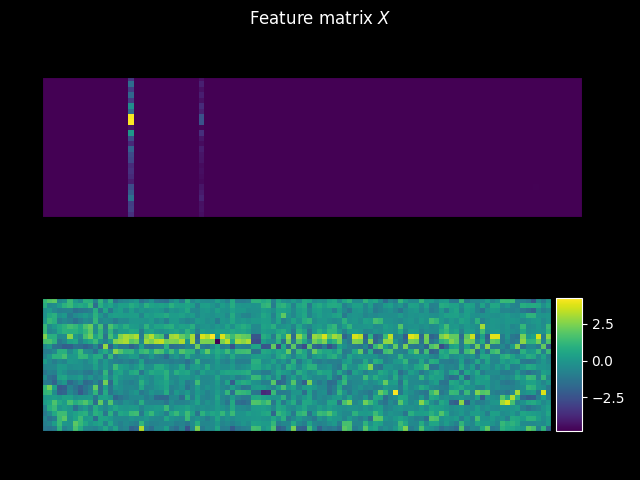

In [11]:
fig,ax = plt.subplots(2,1)
plt.style.use('dark_background')
im0 = ax[0].imshow(X[:,0:100])
im1 = ax[1].imshow(Xin[:,0:100])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('Feature index')
ax[1].set_ylabel('Case')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')
fig.colorbar(im1, cax=cax, orientation='vertical')
ax[1].set_title('Standardized feature matrix')
plt.suptitle('Feature matrix $X$');
plt.tight_layout()

In [24]:
for j in np.arange(1,np.max(subject_id)+1):
    if j in subject_id:
        # Remove the test case
        jj = int(np.where(subject_id==j)[0])
        X_j = np.delete(Xin,jj,0)
        per_change_train_j = np.delete(per_change_train,jj,0)
        # Debug
        # print('Excluding subject',str(subject_id[jj]),'from training feature vector of shape',str(Xin.shape),'to create new training feature vector of shape',str(X_j.shape))
        if (sum(sum(np.isnan(X))))>0:
            print('NaN detected in feature vector')

        # Cross-validation for model selection
        # RidgeCV() does LOOCV by default
        cv = KFold(X_j.shape[0]-2)
        # Identify most important features
        # Do not assume data is centered, fit_intercept=True
        clf_in = RidgeCV(fit_intercept=True).fit(X_j,np.ravel(per_change_train_j))
        sfm = SelectFromModel(clf_in,max_features=100,threshold='mean')
        # Initialize pipeline
        clf = Pipeline([('Ridge',sfm),('SVR',SVR(C=0,epsilon=0,kernel='rbf'))],verbose=1)
        # Select the optimal SVR parameters with grid search
        Cs = ((1e-1,1,10))
        epsilons = ((0.01,0.05,0.1,0.2))
        
        clf_nsvr = GridSearchCV(clf,{'SVR__C':Cs,'SVR__epsilon':epsilons},n_jobs=-1,cv=cv,scoring='neg_mean_squared_error',error_score='raise',verbose=1)
        clf_nsvr.fit(X_j,np.ravel(per_change_train_j))
        ut[jj] = clf_nsvr.best_estimator_.predict(Xin[jj,:].reshape(1, -1) )
        print('Predicted percentage change of',ut[jj],'for case',subject_id[jj])
        print('True percentage change',per_change_train[jj])
        #print(clf_nsvr.best_estimator_.get_params('SVR__epsilon'))
        #print(clf_nsvr.best_estimator_.get_params('SVR__C'))



Fitting 23 folds for each of 12 candidates, totalling 276 fits
[Pipeline] ............. (step 1 of 2) Processing Ridge, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.730394794809277 for case 1
True percentage change [0.83076923]
Fitting 23 folds for each of 12 candidates, totalling 276 fits
[Pipeline] ............. (step 1 of 2) Processing Ridge, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.7073791971451384 for case 2
True percentage change [0.90909091]
Fitting 23 folds for each of 12 candidates, totalling 276 fits
[Pipeline] ............. (step 1 of 2) Processing Ridge, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing SVR, total=   0.0s
Predicted percentage change of 0.7300133971373167 for case 3
True percentage change [0.55555556]
Fitting 23 folds for each of 12 candidates, totalling 276 fits
[Pipeline] ............. (step 1

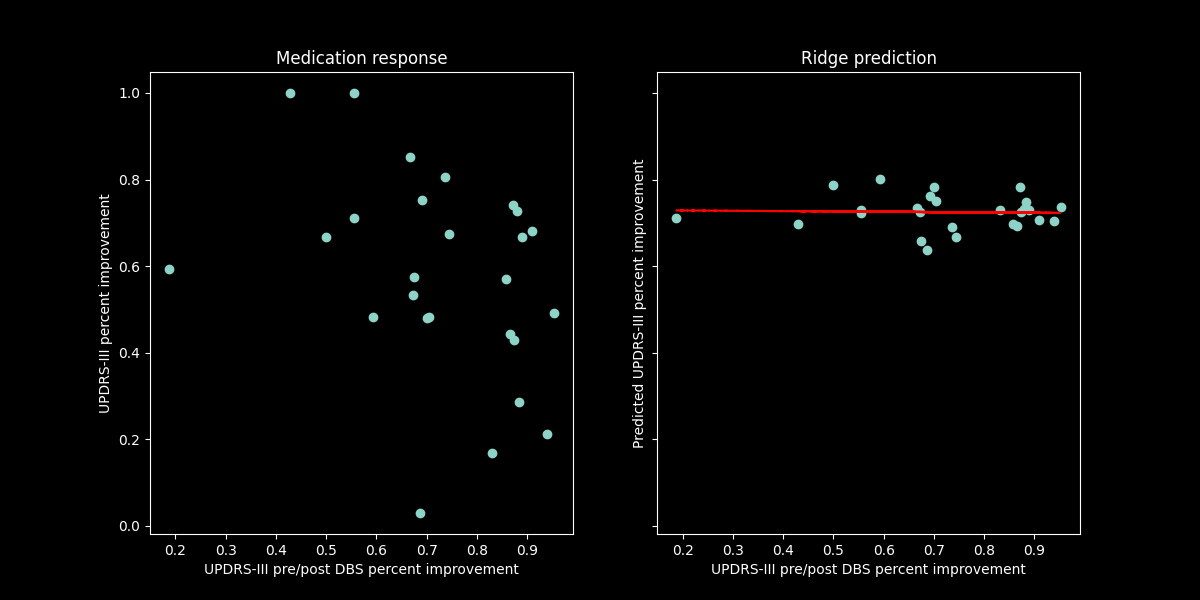

In [25]:

plt.style.use('dark_background')
[fig,ax] = plt.subplots(1,2,sharex=True, sharey=True)
ax[0].scatter(per_change,lct_change)
z = np.polyfit(per_change,lct_change,1)
p = np.poly1d(z)
r2_score(per_change,p(per_change))
ax[0].set_title('Medication response')
ax[0].set_xlabel("UPDRS-III pre/post DBS percent improvement")
ax[0].set_ylabel("UPDRS-III percent improvement")
ax[1].scatter(per_change,ut)
z = np.polyfit(per_change,ut,1)
p = np.poly1d(z)
ax[1].plot(per_change,p(per_change),"r--")
ax[1].set_title('Ridge prediction')
ax[1].set_xlabel("UPDRS-III pre/post DBS percent improvement")
ax[1].set_ylabel("Predicted UPDRS-III percent improvement")
fig.set_size_inches(12, 6)
plt.show()

In [26]:
r2_score(per_change,p(per_change))

-0.01497648647855998

In [27]:
z = np.polyfit(per_change,lct_change,1)
p = np.poly1d(z)
r2_score(per_change,p(per_change))

-1.8041590503366502

In [28]:
feats = clf_nsvr.best_estimator_.steps[0][1].get_support()
for k in range(feats.__len__()-1):
    if feats[k] == True:
        with open('ridge_feats.txt', 'a') as f:
            f.write(keys[k])
        print(keys[k])



original_shape_Maximum2DDiameterRow
original_glszm_SizeZoneNonUniformityNormalized
original_glszm_SmallAreaEmphasis
gradient_glcm_InverseVariance
gradient_glcm_MaximumProbability
gradient_gldm_DependenceVariance
gradient_glrlm_RunEntropy
gradient_glszm_GrayLevelNonUniformityNormalized
gradient_glszm_SizeZoneNonUniformityNormalized
gradient_glszm_SmallAreaEmphasis
lbp-2D_firstorder_10Percentile
lbp-2D_firstorder_Mean
lbp-2D_firstorder_Skewness
lbp-3D-m1_firstorder_Maximum
lbp-3D-k_glszm_GrayLevelNonUniformity
lbp-3D-k_glszm_GrayLevelNonUniformityNormalized
lbp-3D-k_glszm_GrayLevelVariance
lbp-3D-k_glszm_SizeZoneNonUniformityNormalized
lbp-3D-k_glszm_ZoneEntropy
logarithm_glszm_LargeAreaLowGrayLevelEmphasis
logarithm_ngtdm_Busyness
square_glcm_Correlation
square_glcm_MCC
square_glszm_GrayLevelNonUniformity
square_glszm_GrayLevelNonUniformityNormalized
square_glszm_LowGrayLevelZoneEmphasis
square_glszm_SizeZoneNonUniformity
square_glszm_SizeZoneNonUniformityNormalized
square_glszm_SmallAr

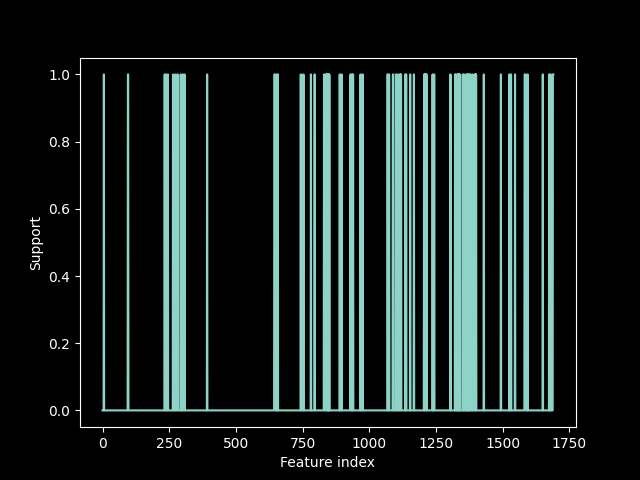

In [29]:

plt.style.use('dark_background')
fig,ax = plt.subplots(1,1)
plt.plot(feats)
plt.xlabel('Feature index')
plt.ylabel('Support')
plt.show()

In [30]:
clf_nsvr.best_estimator_.steps[1][1].support_vectors_.shape

(15, 100)

In [31]:
np.array(clf_nsvr.best_estimator_.predict(X))

array([0.67990886, 0.67990886, 0.67990886, 0.67990886, 0.67990886,
       0.67990886, 0.67990886, 0.67990886, 0.67990886, 0.67990886,
       0.67990886, 0.67990886, 0.67990886, 0.67990886, 0.67990886,
       0.67990886, 0.67990886, 0.67990886, 0.67990886, 0.67990886,
       0.67990886, 0.67990886, 0.67990886, 0.67990886, 0.67990886,
       0.67990886])

ValueError: x and y must be the same size

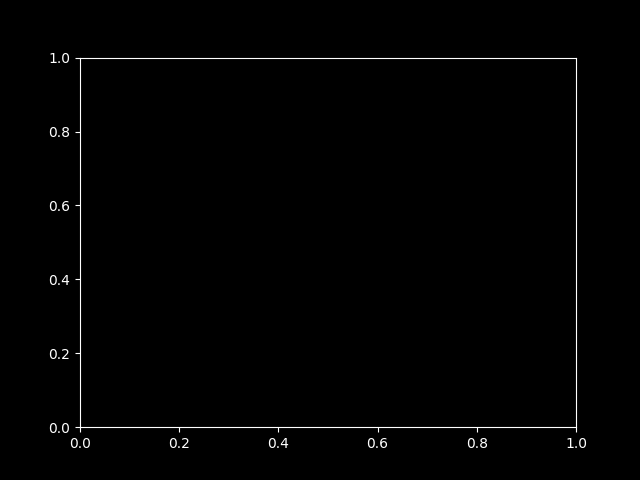

In [32]:
cases = np.linspace(1,n_cases-1,n_cases-1)
fig,ax = plt.subplots(1,1)
sv_ind = clf_nsvr.best_estimator_.steps[1][1].support_
# Plot remaining data
plt.scatter(cases, per_change_train, label="data", zorder=2, c="c", edgecolors=(0, 0, 0))
# Plot support vectors
plt.scatter(
    cases[sv_ind],
    per_change[sv_ind],
    s=50,
    c="m",
    label="SVR support vectors",
    zorder=2,
    edgecolors=(0, 0, 0))


plt.plot(cases,np.array(clf_nsvr.best_estimator_.predict(X))),
plt.style.use('dark_background')
plt.show()

In [ ]:
X_SVR = clf_nsvr.best_estimator_.steps[1][1].support_vectors_
fig,ax = plt.subplots(1,1)
im_svr = plt.imshow(X_SVR)
plt.xticks([])
plt.yticks([])
plt.xlabel('Selected feature index')
plt.ylabel('Class')
plt.title('Support vectors weights');
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im_svr,cax=cax,orientation='vertical')
plt.style.use('dark_background')

In [ ]:
X_Lasso = clf_nsvr.best_estimator_.steps[0][1]._transform(X_t)


fig,ax = plt.subplots(1,1)
plt.stem(X_Lasso.ravel())
plt.xticks([])
plt.yticks([])
plt.xlabel('Selected feature index')
plt.ylabel('Feature weight index')
plt.title('Lasso feature weights');
plt.style.use('dark_background')